## Imports


In [1]:
import pandas as pd
import numpy as np

## Loading Dataset


In [12]:
# i want to put a json object in a pandas dataframe
df_1 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/AO_Output.json"
)
df_2 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/FA Output.json"
)
df_3 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/girlies__data.json"
)
df_4 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/integrated_data.json"
)
df_5 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/nadines_video_annotated.json"
)
df_6 = pd.read_json(
    "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/video_1_annotated.json"
)

In [13]:
# add an index column to each dataframe
df_1["index"] = 1
df_2["index"] = 2
df_3["index"] = 3
df_4["index"] = 4
df_5["index"] = 5
df_6["index"] = 6

In [14]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6], ignore_index=True)

In [15]:
df.shape

(40637, 6)

In [ ]:
df["event"].value_counts()

event
backhand    358
forehand    215
Name: count, dtype: int64

In [17]:
expanded_df = (
    df["keypoints"]
    .apply(
        lambda person: {f"x_{part}": person[part]["x"] for part in person}
        | {f"y_{part}": person[part]["y"] for part in person}
    )
    .apply(pd.Series)
)

# Merge back into original df if needed
df_expanded = pd.concat([df, expanded_df], axis=1)

# Optionally drop original nested column
df_expanded.drop(columns=["keypoints"], inplace=True)

In [18]:
df_expanded.shape

(40637, 29)

In [ ]:
df_expanded

In [ ]:
df_expanded["event"].value_counts()

event
backhand    358
forehand    215
Name: count, dtype: int64

In [20]:
# Assuming your DataFrame is called df_expanded and is indexed properly (0, 1, 2, ...)
event_indices = df_expanded[df_expanded["event"].notnull()].index

# Set to store all the indices we want (to avoid duplicates)
selected_indices = set()

for idx in event_indices:
    label = df_expanded.at[idx, "event"]  # Label for current event
    selected_indices.add(idx)
    df_expanded.at[idx, "event"] = label  # Ensure label is consistent

    # Include next up to 15 rows, but stop early if another event is found
    for offset in range(1, 16):  # 1 to 15
        next_idx = idx + offset
        if next_idx >= len(df_expanded):
            break

        if (
            pd.notnull(df_expanded.at[next_idx, "event"])
            or df_expanded["index"][next_idx] != df_expanded["index"][idx]
        ):
            break  # Stop if another event is found

        selected_indices.add(next_idx)
        df_expanded.at[next_idx, "event"] = label  # Assign current label

# Keep only selected rows
# df_expanded = df_expanded.loc[sorted(selected_indices)].reset_index(drop=True)

In [22]:
df_expanded.shape

(40637, 29)

In [23]:
df_expanded["event"].value_counts()

event
backhand    5617
forehand    3355
Name: count, dtype: int64

In [8]:
event_indices = df_expanded[df_expanded["event"].notnull()].index

selected_indices = set()
neither_count = 0
MAX_NEITHER_SEGMENTS = 250

# Step 1: Annotate labeled events and their 15-frame tails
for idx in event_indices:
    label = df_expanded.at[idx, "event"]
    group_id = df_expanded.at[idx, "index"]
    selected_indices.add(idx)
    df_expanded.at[idx, "event"] = label

    for offset in range(1, 16):
        next_idx = idx + offset
        if next_idx >= len(df_expanded):
            break

        if (
            pd.notnull(df_expanded.at[next_idx, "event"])
            or df_expanded.at[next_idx, "index"] != group_id
        ):
            break

        selected_indices.add(next_idx)
        df_expanded.at[next_idx, "event"] = label

# Step 2: Annotate null event segments in 16-frame "neither" batches
null_indices = df_expanded[df_expanded["event"].isnull()].index
null_indices = sorted(null_indices)

i = 0
while i < len(null_indices):
    if neither_count >= MAX_NEITHER_SEGMENTS:
        break

    start_idx = null_indices[i]
    group_id = df_expanded.at[start_idx, "index"]

    # Collect consecutive nulls in same group
    segment = [start_idx]
    for j in range(i + 1, len(null_indices)):
        current_idx = null_indices[j]
        prev_idx = null_indices[j - 1]

        if (
            current_idx == prev_idx + 1
            and df_expanded.at[current_idx, "index"] == group_id
        ):
            segment.append(current_idx)
        else:
            break

    # Process in batches of 16
    for k in range(0, len(segment), 16):
        if neither_count >= MAX_NEITHER_SEGMENTS:
            break

        batch = segment[k : k + 16]
        if len(batch) == 16:
            for idx in batch:
                selected_indices.add(idx)
                df_expanded.at[idx, "event"] = "neither"
            neither_count += 1

    i += len(segment)

# Step 3: Final filtering
df_expanded = df_expanded.loc[sorted(selected_indices)].reset_index(drop=True)

print(f"Number of 'neither' segments (16-frame batches): {neither_count}")

Number of 'neither' segments (16-frame batches): 250


In [9]:
# check if there are any null values in the dataframe
print(df_expanded.isnull().sum())

frame               0
time                0
event               0
player_id           0
index               0
x_left_shoulder     0
x_right_shoulder    0
x_left_elbow        0
x_right_elbow       0
x_left_wrist        0
x_right_wrist       0
x_left_hip          0
x_right_hip         0
x_left_knee         0
x_right_knee        0
x_left_ankle        0
x_right_ankle       0
y_left_shoulder     0
y_right_shoulder    0
y_left_elbow        0
y_right_elbow       0
y_left_wrist        0
y_right_wrist       0
y_left_hip          0
y_right_hip         0
y_left_knee         0
y_right_knee        0
y_left_ankle        0
y_right_ankle       0
dtype: int64


In [10]:
df_expanded.shape

(20512, 29)

In [11]:
df_expanded["event"].value_counts()

event
backhand    10323
forehand     6189
neither      4000
Name: count, dtype: int64

In [10]:
df_expanded.to_csv("annotated_jsons/combined_data_2.csv", index=False)

## Better Approach (LSTM - 30 Frames per event)


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [12]:
lstm_df = df_expanded.copy()

In [13]:
# ----------------------------
# Step 1: Normalize coordinates
# ----------------------------
coord_cols = [
    col for col in lstm_df.columns if col.startswith("x") or col.startswith("y")
]
scaler = MinMaxScaler()
lstm_df[coord_cols] = scaler.fit_transform(lstm_df[coord_cols])

In [14]:
lstm_df.drop(columns=["player_id", "time", "index"], inplace=True)

In [15]:
# Step 2: Label encoding
# ----------------------------
label_map = {"forehand": 0, "backhand": 1, "neither": 2}
lstm_df = lstm_df[lstm_df["event"].isin(label_map.keys())].copy()
lstm_df["event"] = lstm_df["event"].map(label_map).astype(int)

In [16]:
# Data preparation with non-overlapping windows
X = []
y = []
window_size = 16

# Process the data in non-overlapping chunks of size 16
for i in range(0, len(lstm_df), window_size):
    # Check if we have a full window
    if i + window_size <= len(lstm_df):
        window = lstm_df.iloc[i : i + window_size]

        # Only use the window if all rows have the same event
        if window["event"].nunique() == 1:
            X.append(
                window[coord_cols].values
            )  # Shape: (16, 24) - 16 timesteps, 24 features
            # Store the single event for this window
            y.append(window["event"].iloc[0])

X = np.array(X)  # shape should be (num_non_overlapping_windows, 16, 24)
y = np.array(y)  # shape should be (num_non_overlapping_windows,)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Label distribution: {np.unique(y, return_counts=True)}")

X shape: (788, 16, 24)
y shape: (788,)
Label distribution: (array([0, 1, 2]), array([220, 408, 160]))


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
model = Sequential()
# Input shape: (16 timesteps, 24 features)
model.add(LSTM(4, input_shape=(window_size, len(coord_cols)), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(3, activation="softmax"))  # 3 classes (0, 1, 2)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

/Users/youssef/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# ----------------------------
# Step 6: Training
# ----------------------------
# Early stopping
# early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,  # You can adjust this batch size for training
    # callbacks=[early_stop],
    verbose=1,
)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5952 - loss: 0.9487 - val_accuracy: 0.7025 - val_loss: 0.8101
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6855 - loss: 0.7822 - val_accuracy: 0.7215 - val_loss: 0.6672
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7134 - loss: 0.7043 - val_accuracy: 0.7532 - val_loss: 0.6053
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7755 - loss: 0.6211 - val_accuracy: 0.7785 - val_loss: 0.5917
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7884 - loss: 0.5657 - val_accuracy: 0.8038 - val_loss: 0.5647
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7992 - loss: 0.5451 - val_accuracy: 0.8038 - val_loss: 0.5132
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7956 - loss: 0.5631 - val_accuracy: 0.8228 - val_loss: 0.5028
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8015 - loss: 0.5332 - val_accuracy: 0.7975 - val_loss:

In [25]:
# print classification report


# Evaluate the model
y_pred = np.argmax(model.predict(X_val), axis=1)
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        44
           1       0.90      0.87      0.88        82
           2       0.74      0.78      0.76        32

    accuracy                           0.84       158
   macro avg       0.81      0.82      0.82       158
weighted avg       0.84      0.84      0.84       158



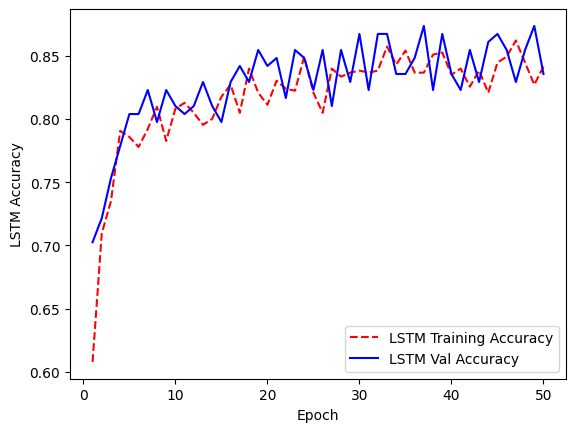

In [26]:
# Get training and validation accuracy histories
import matplotlib.pyplot as plt

training_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

EPOCHS = len(training_acc)

# Create count of the number of epochs
epoch_count = range(1, EPOCHS + 1)

# Visualize accuracy history
plt.figure()
plt.plot(epoch_count, training_acc, "r--")
plt.plot(epoch_count, val_acc, "b-")
plt.legend(["LSTM Training Accuracy", "LSTM Val Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("LSTM Accuracy")
plt.show()